In [3]:
import os
import json
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
import re
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from tqdm import tqdm
PATH = "./sample_data/"
tqdm.pandas()
%matplotlib inline

In [9]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [4]:
df = pd.read_json("./aerospace_11.json")

In [5]:
def preprocess_text(text, flag):
    text = text.lower()
    text = text.replace("abstract:","")
    text = re.sub("[^A-Za-z]+"," ",text)
    if flag:
        tokens = nltk.word_tokenize(text)
        tokens = [token for token in tokens if not token in stopwords.words("english")]
        text = " ".join(tokens)
    return text

def preprocess_date(text):
  if len(text)>len("24 Jan 2022"):
    cre_date = re.compile(r"([0-9]{1,2}[ ]{1,3}(Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)[ ]{1,3}[0-9]{4})")
    match = re.search(cre_date,text) 
    if len(match.groups())>0:
      return datetime.strptime(match.groups()[0].strip(), '%d %b %Y')
  else:
    return datetime.strptime(text, '%d %b %Y')

In [6]:
df["categories"].tolist()

[['Fluid Dynamics (physics.flu-dyn)'],
 ['Fluid Dynamics (physics.flu-dyn)'],
 ['Computational Physics (physics.comp-ph)'],
 ['Computational Physics (physics.comp-ph)', ' Numerical Analysis (math.NA)'],
 ['Fluid Dynamics (physics.flu-dyn)'],
 ['Chaotic Dynamics (nlin.CD)'],
 ['Systems and Control (eess.SY)'],
 ['Data Structures and Algorithms (cs.DS)'],
 ['Software Engineering (cs.SE)'],
 ['Software Engineering (cs.SE)'],
 ['Space Physics (physics.space-ph)',
  ' Instrumentation and Methods for Astrophysics (astro-ph.IM)'],
 ['Instrumentation and Methods for Astrophysics (astro-ph.IM)'],
 ['Soft Condensed Matter (cond-mat.soft)'],
 ['Information Theory (cs.IT)'],
 ['Robotics (cs.RO)'],
 ['Systems and Control (eess.SY)'],
 ['Earth and Planetary Astrophysics (astro-ph.EP)'],
 ['Information Theory (cs.IT)'],
 ['Optimization and Control (math.OC)'],
 ['Solar and Stellar Astrophysics (astro-ph.SR)'],
 ['Other Computer Science (cs.OH)'],
 ['Systems and Control (eess.SY)', ' Optimization and 

In [7]:
for row in df.iterrows():
  print(preprocess_date(row[1]['date_publ']))
  break

2014-02-24 00:00:00


In [10]:
df['cleaned_abstract'] = df['abstract'].progress_apply(lambda x: preprocess_text(x,True))

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 47.78it/s]


In [11]:
df["date_format"] = df["date_publ"].progress_apply(preprocess_date)

100%|███████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 25088.55it/s]


In [12]:
df["month"]=df["date_format"].apply(lambda x: x.month)
df["year"]=df["date_format"].apply(lambda x: x.year)

In [13]:
vecr = TfidfVectorizer(min_df=5, max_df=0.95)
X = vecr.fit_transform(df["cleaned_abstract"])

In [14]:
N_CLASS = 6
kmeans = KMeans(n_clusters=N_CLASS,random_state=111)
kmeans.fit(X)

KMeans(n_clusters=6, random_state=111)

In [15]:
clusters = kmeans.labels_

In [16]:
len(list(clusters))

50

In [17]:
svd = TruncatedSVD(n_components=2, random_state=111)
svd_vec = svd.fit_transform(X)

In [18]:
svd_vec.shape

(50, 2)

In [19]:
df['cluster'] = clusters

In [20]:
df['y'] = svd_vec[:,0]
df['x'] = svd_vec[:,1]

In [21]:
def interpret(n):
  res = dict()
  centroids = pd.DataFrame(X.todense()).groupby(clusters).mean()
  terms = vecr.get_feature_names_out()
  for i,r in centroids.iterrows():
    res[i] = ",".join([terms[t] for t in np.argsort(r)[-n:]])
  return res

In [22]:
cluster_map = interpret(3)
df['labels'] = df['cluster'].map(cluster_map)

In [23]:
df[["title","categories","cluster"]].head()

,title,categories,cluster
0,Title:Numerical and Experimental Studies on th...,[Fluid Dynamics (physics.flu-dyn)],3
1,Title:LES Study on the Mechanism of Vortex Rin...,[Fluid Dynamics (physics.flu-dyn)],3
2,Title:Universal High Order Subroutine with New...,[Computational Physics (physics.comp-ph)],3
3,Title:Improvement of Mixing Function for Modif...,"[Computational Physics (physics.comp-ph), Num...",3
4,Title:Numerical Study of Mechanism of U-shaped...,[Fluid Dynamics (physics.flu-dyn)],3


<AxesSubplot:title={'center':'The first vizualization at the course'}, xlabel='x', ylabel='y'>

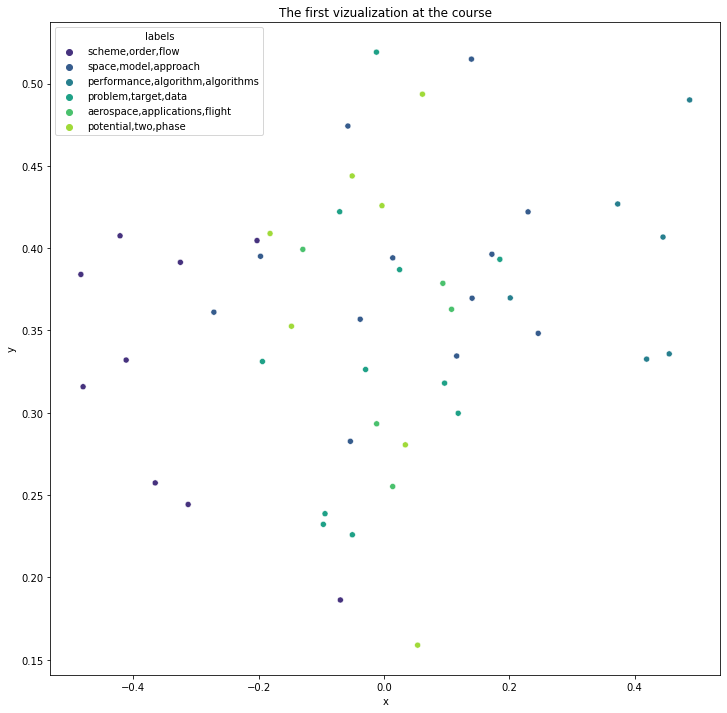

In [24]:
plt.figure(figsize=(12,12))
plt.title("The first vizualization at the course")
sns.scatterplot(data=df,y='y',x='x', hue='labels',palette='viridis')

In [25]:
df = pd.concat([df,pd.get_dummies(df["cluster"],prefix='class')],axis=1)

In [26]:
df

,url,title,date_publ,authors,abstract,categories,url_pdf,cleaned_abstract,date_format,month,...,cluster,y,x,labels,class_0,class_1,class_2,class_3,class_4,class_5
0,https://arxiv.org/abs/1402.5891,Title:Numerical and Experimental Studies on th...,24 Feb 2014,"[Qin Li, Yonghua Yan, Ping Lu, Adam Pierce, Ch...","Abstract: In this paper, the implicitly imple...",[Fluid Dynamics (physics.flu-dyn)],/pdf/1402.5891,paper implicitly implemented les method fifth ...,2014-02-24,2,...,3,0.407515,-0.421085,"scheme,order,flow",0,0,0,1,0,0
1,https://arxiv.org/abs/1402.5889,Title:LES Study on the Mechanism of Vortex Rin...,24 Feb 2014,"[Yonghua Yan, Caixia Chen, Ping Lu, Chaoqun Li]","Abstract: In this study, we investigate the i...",[Fluid Dynamics (physics.flu-dyn)],/pdf/1402.5889,study investigate interaction vortex rings beh...,2014-02-24,2,...,3,0.315857,-0.480064,"scheme,order,flow",0,0,0,1,0,0
2,https://arxiv.org/abs/1402.5885,Title:Universal High Order Subroutine with New...,24 Feb 2014,"[M. Oliveria, P. Lu, X. Liu, C. Li]",Abstract: The goal of this work is to develop...,[Computational Physics (physics.comp-ph)],/pdf/1402.5885,goal work develop new universal high order sub...,2014-02-24,2,...,3,0.384047,-0.483569,"scheme,order,flow",0,0,0,1,0,0
3,https://arxiv.org/abs/1402.5882,Title:Improvement of Mixing Function for Modif...,24 Feb 2014,"[Huankun Fu, Ping Lu, Chaoqun Li]",Abstract: The compact scheme has high order a...,"[Computational Physics (physics.comp-ph), Num...",/pdf/1402.5882,compact scheme high order accuracy high resolu...,2014-02-24,2,...,3,0.244360,-0.312425,"scheme,order,flow",0,0,0,1,0,0
4,https://arxiv.org/abs/1402.5877,Title:Numerical Study of Mechanism of U-shaped...,24 Feb 2014,"[Ping Lu, Qin Li, Chaoqun Li]",Abstract: This paper illustrates the mechanis...,[Fluid Dynamics (physics.flu-dyn)],/pdf/1402.5877,paper illustrates mechanism u shaped vortex fo...,2014-02-24,2,...,3,0.391414,-0.324827,"scheme,order,flow",0,0,0,1,0,0
5,https://arxiv.org/abs/1402.5873,Title:Numerical Study on Randomization in Late...,24 Feb 2014,"[Ping Lu, Manoj Thapa, Chaoqun Li]",Abstract: The mechanism of randomization in l...,[Chaotic Dynamics (nlin.CD)],/pdf/1402.5873,mechanism randomization late boundary layer tr...,2014-02-24,2,...,3,0.257447,-0.364958,"scheme,order,flow",0,0,0,1,0,0
6,https://arxiv.org/abs/1402.5586,Title:Adaptive Zero Reaction Motion Control fo...,"23 Feb 2014 (v1), last revised 14 Dec 2015 (th...","[Shuanfeng Xu, Hanlei Wang, Duzhou Zhang, Baoh...",Abstract: This paper investigates adaptive ze...,[Systems and Control (eess.SY)],/pdf/1402.5586,paper investigates adaptive zero reaction moti...,2014-02-23,2,...,2,0.396317,0.172301,"space,model,approach",0,0,1,0,0,0
7,https://arxiv.org/abs/1402.2710,Title:Direction Finding Algorithms with Joint ...,12 Feb 2014,"[L. Wang, R. C. de Lamare, M. Haard]","Abstract: In this paper, a reduced-rank schem...",[Data Structures and Algorithms (cs.DS)],/pdf/1402.2710,paper reduced rank scheme joint iterative opti...,2014-02-12,2,...,4,0.332623,0.419125,"performance,algorithm,algorithms",0,0,0,0,1,0
8,https://arxiv.org/abs/1401.4802,Title:Process Evolution Supported by Rationale...,20 Jan 2014,"[Alexis Ocampo, Jürgen Münc]",Abstract: Evolving a software process model w...,[Software Engineering (cs.SE)],/pdf/1401.4802,evolving software process model without retros...,2014-01-20,1,...,1,0.225935,-0.050384,"problem,target,data",0,1,0,0,0,0
9,https://arxiv.org/abs/1401.1910,Title:Aligning Software-related Strategies in ...,9 Jan 2014,"[Martin Kowalczyk, Jürgen Münch, Masafumi Kata...",Abstract: Aligning the activities of an organ...,[Software Engineering (cs.SE)],/pdf/1401.1910,aligning activities organization business goal...,2014-01-09,1,...,2,0.356849,-0.037875,"space,model,approach",0,0,1,0,0,0


In [27]:
buff = df.groupby(["year","month"])
buff = buff[[f"class_{ind}" for ind in range(0,N_CLASS)]].sum()

In [28]:
buff

class_0  class_1  class_2  class_3  class_4  class_5
year month                                                      
2012 6            0        0        1        0        1        0
     7            1        1        1        0        1        1
     9            1        1        0        0        0        4
     12           0        1        0        0        1        0
2013 2            1        0        0        0        1        0
     3            1        1        0        0        0        0
     4            0        2        0        1        0        0
     5            0        0        1        0        0        0
     6            0        0        0        1        0        1
     7            0        1        0        0        0        1
     8            0        0        2        0        0        0
     9            0        1        2        1        0        0
     11           0        0        3        0        1        0
     12           1        1        0        0        0        0
2014 1            0        2        1        0        0        0
     2            0        0        1        6        1        0

<AxesSubplot:xlabel='year,month'>

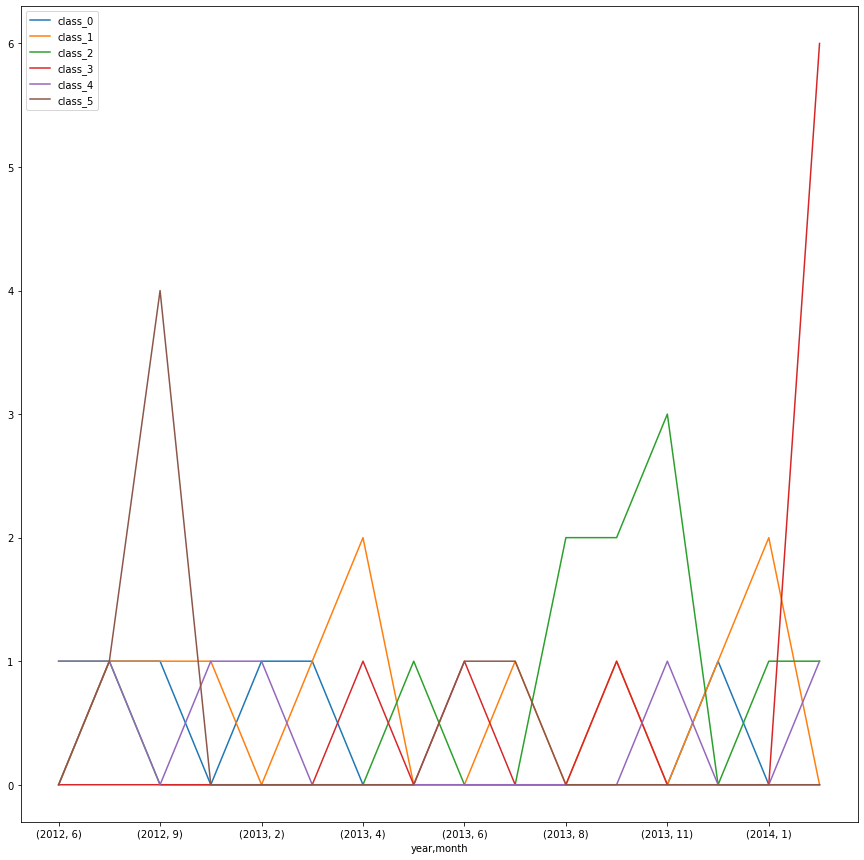

In [29]:
buff.plot(y=[f"class_{ind}" for ind in range(0,N_CLASS)],figsize=(15,15))

In [219]:
print(df["categories"])

0                    [Fluid Dynamics (physics.flu-dyn)]
1                    [Fluid Dynamics (physics.flu-dyn)]
2             [Computational Physics (physics.comp-ph)]
3     [Computational Physics (physics.comp-ph),  Num...
4                    [Fluid Dynamics (physics.flu-dyn)]
5                          [Chaotic Dynamics (nlin.CD)]
6                       [Systems and Control (eess.SY)]
7              [Data Structures and Algorithms (cs.DS)]
8                        [Software Engineering (cs.SE)]
9                        [Software Engineering (cs.SE)]
10    [Space Physics (physics.space-ph),  Instrument...
11    [Instrumentation and Methods for Astrophysics ...
12              [Soft Condensed Matter (cond-mat.soft)]
13                         [Information Theory (cs.IT)]
14                                   [Robotics (cs.RO)]
15                      [Systems and Control (eess.SY)]
16     [Earth and Planetary Astrophysics (astro-ph.EP)]
17                         [Information Theory (

In [235]:
categories = df["categories"].tolist()

In [233]:
result = []
[ result.extend(el) for el in categories] 
len(result)

64

In [230]:
def list_to_set_conversion(list1):
    convertedSet = set()
    for x in list1:
        convertedSet.add(x)
    return convertedSet

In [238]:
categorySet = list_to_set_conversion(result)
updatedCategorySet = set();
for val in categorySet:
    if (val[0] != ' '):
        updatedCategorySet.add(val);
print(updatedCategorySet)


{'Space Physics (physics.space-ph)', 'Computational Engineering, Finance, and Science (cs.CE)', 'Solar and Stellar Astrophysics (astro-ph.SR)', 'Soft Condensed Matter (cond-mat.soft)', 'Artificial Intelligence (cs.AI)', 'Optimization and Control (math.OC)', 'Pattern Formation and Solitons (nlin.PS)', 'Information Theory (cs.IT)', 'Other Computer Science (cs.OH)', 'Software Engineering (cs.SE)', 'Cryptography and Security (cs.CR)', 'Instrumentation and Methods for Astrophysics (astro-ph.IM)', 'Rings and Algebras (math.RA)', 'Materials Science (cond-mat.mtrl-sci)', 'Computation (stat.CO)', 'Robotics (cs.RO)', 'Earth and Planetary Astrophysics (astro-ph.EP)', 'Analysis of PDEs (math.AP)', 'Chaotic Dynamics (nlin.CD)', 'Data Structures and Algorithms (cs.DS)', 'Fluid Dynamics (physics.flu-dyn)', 'Systems and Control (eess.SY)', 'Applications (stat.AP)', 'Computational Physics (physics.comp-ph)', 'Human-Computer Interaction (cs.HC)'}


In [239]:
df["categories"].apply(lambda x: x[0])

0                      Fluid Dynamics (physics.flu-dyn)
1                      Fluid Dynamics (physics.flu-dyn)
2               Computational Physics (physics.comp-ph)
3               Computational Physics (physics.comp-ph)
4                      Fluid Dynamics (physics.flu-dyn)
5                            Chaotic Dynamics (nlin.CD)
6                         Systems and Control (eess.SY)
7                Data Structures and Algorithms (cs.DS)
8                          Software Engineering (cs.SE)
9                          Software Engineering (cs.SE)
10                     Space Physics (physics.space-ph)
11    Instrumentation and Methods for Astrophysics (...
12                Soft Condensed Matter (cond-mat.soft)
13                           Information Theory (cs.IT)
14                                     Robotics (cs.RO)
15                        Systems and Control (eess.SY)
16       Earth and Planetary Astrophysics (astro-ph.EP)
17                           Information Theory 

In [240]:
categoryDf = df = pd.concat([df,pd.get_dummies(df["categories"].apply(lambda x: x[0]),prefix='category')],axis=1)
categoryDf


,url,title,date_publ,authors,abstract,categories,url_pdf,cleaned_abstract,date_format,month,...,category_Optimization and Control (math.OC),category_Other Computer Science (cs.OH),category_Pattern Formation and Solitons (nlin.PS),category_Rings and Algebras (math.RA),category_Robotics (cs.RO),category_Soft Condensed Matter (cond-mat.soft),category_Software Engineering (cs.SE),category_Solar and Stellar Astrophysics (astro-ph.SR),category_Space Physics (physics.space-ph),category_Systems and Control (eess.SY)
0,https://arxiv.org/abs/1402.5891,Title:Numerical and Experimental Studies on th...,24 Feb 2014,"[Qin Li, Yonghua Yan, Ping Lu, Adam Pierce, Ch...","Abstract: In this paper, the implicitly imple...",[Fluid Dynamics (physics.flu-dyn)],/pdf/1402.5891,paper implicitly implemented les method fifth ...,2014-02-24,2,...,0,0,0,0,0,0,0,0,0,0
1,https://arxiv.org/abs/1402.5889,Title:LES Study on the Mechanism of Vortex Rin...,24 Feb 2014,"[Yonghua Yan, Caixia Chen, Ping Lu, Chaoqun Li]","Abstract: In this study, we investigate the i...",[Fluid Dynamics (physics.flu-dyn)],/pdf/1402.5889,study investigate interaction vortex rings beh...,2014-02-24,2,...,0,0,0,0,0,0,0,0,0,0
2,https://arxiv.org/abs/1402.5885,Title:Universal High Order Subroutine with New...,24 Feb 2014,"[M. Oliveria, P. Lu, X. Liu, C. Li]",Abstract: The goal of this work is to develop...,[Computational Physics (physics.comp-ph)],/pdf/1402.5885,goal work develop new universal high order sub...,2014-02-24,2,...,0,0,0,0,0,0,0,0,0,0
3,https://arxiv.org/abs/1402.5882,Title:Improvement of Mixing Function for Modif...,24 Feb 2014,"[Huankun Fu, Ping Lu, Chaoqun Li]",Abstract: The compact scheme has high order a...,"[Computational Physics (physics.comp-ph), Num...",/pdf/1402.5882,compact scheme high order accuracy high resolu...,2014-02-24,2,...,0,0,0,0,0,0,0,0,0,0
4,https://arxiv.org/abs/1402.5877,Title:Numerical Study of Mechanism of U-shaped...,24 Feb 2014,"[Ping Lu, Qin Li, Chaoqun Li]",Abstract: This paper illustrates the mechanis...,[Fluid Dynamics (physics.flu-dyn)],/pdf/1402.5877,paper illustrates mechanism u shaped vortex fo...,2014-02-24,2,...,0,0,0,0,0,0,0,0,0,0
5,https://arxiv.org/abs/1402.5873,Title:Numerical Study on Randomization in Late...,24 Feb 2014,"[Ping Lu, Manoj Thapa, Chaoqun Li]",Abstract: The mechanism of randomization in l...,[Chaotic Dynamics (nlin.CD)],/pdf/1402.5873,mechanism randomization late boundary layer tr...,2014-02-24,2,...,0,0,0,0,0,0,0,0,0,0
6,https://arxiv.org/abs/1402.5586,Title:Adaptive Zero Reaction Motion Control fo...,"23 Feb 2014 (v1), last revised 14 Dec 2015 (th...","[Shuanfeng Xu, Hanlei Wang, Duzhou Zhang, Baoh...",Abstract: This paper investigates adaptive ze...,[Systems and Control (eess.SY)],/pdf/1402.5586,paper investigates adaptive zero reaction moti...,2014-02-23,2,...,0,0,0,0,0,0,0,0,0,1
7,https://arxiv.org/abs/1402.2710,Title:Direction Finding Algorithms with Joint ...,12 Feb 2014,"[L. Wang, R. C. de Lamare, M. Haard]","Abstract: In this paper, a reduced-rank schem...",[Data Structures and Algorithms (cs.DS)],/pdf/1402.2710,paper reduced rank scheme joint iterative opti...,2014-02-12,2,...,0,0,0,0,0,0,0,0,0,0
8,https://arxiv.org/abs/1401.4802,Title:Process Evolution Supported by Rationale...,20 Jan 2014,"[Alexis Ocampo, Jürgen Münc]",Abstract: Evolving a software process model w...,[Software Engineering (cs.SE)],/pdf/1401.4802,evolving software process model without retros...,2014-01-20,1,...,0,0,0,0,0,0,1,0,0,0
9,https://arxiv.org/abs/1401.1910,Title:Aligning Software-related Strategies in ...,9 Jan 2014,"[Martin Kowalczyk, Jürgen Münch, Masafumi Kata...",Abstract: Aligning the activities of an organ...,[Software Engineering (cs.SE)],/pdf/1401.1910,aligning activities organization business goal...,2014-01-09,1,...,0,0,0,0,0,0,1,0,0,0


In [243]:
categoryBuff = categoryDf.groupby(["title"])
categoryBuff = categoryBuff[[f"category_{ind}" for ind in updatedCategorySet]].sum()
categoryBuff

,category_Space Physics (physics.space-ph),category_Space Physics (physics.space-ph),category_Space Physics (physics.space-ph),"category_Computational Engineering, Finance, and Science (cs.CE)","category_Computational Engineering, Finance, and Science (cs.CE)","category_Computational Engineering, Finance, and Science (cs.CE)",category_Solar and Stellar Astrophysics (astro-ph.SR),category_Solar and Stellar Astrophysics (astro-ph.SR),category_Solar and Stellar Astrophysics (astro-ph.SR),category_Soft Condensed Matter (cond-mat.soft),...,category_Systems and Control (eess.SY),category_Applications (stat.AP),category_Applications (stat.AP),category_Applications (stat.AP),category_Computational Physics (physics.comp-ph),category_Computational Physics (physics.comp-ph),category_Computational Physics (physics.comp-ph),category_Human-Computer Interaction (cs.HC),category_Human-Computer Interaction (cs.HC),category_Human-Computer Interaction (cs.HC)
title,,,,,,,,,,,,,,,,,,,,,
Title:A new dynamical indicator for chaos detection in galactic Hamiltonian systems,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Title:A particle filter approach to approximate posterior Cramér-Rao lower bound,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Title:Adaptive Zero Reaction Motion Control for Free-Floating Space Manipulators,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
Title:Advanced robot calibration using partial pose measurements,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Title:Aligning Software-related Strategies in Multi-Organizational Settings,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Title:An Analytic Solution to Wahba's Problem,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Title:An Approach to Model Interest for Planetary Rover through Dezert-Smarandache Theory,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Title:Analytical and experimental stability investigation of a hardware-in-the-loop satellite docking simulator,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Title:Approximate evaluation of marginal association probabilities with belief propagation,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<AxesSubplot:xlabel='title'>

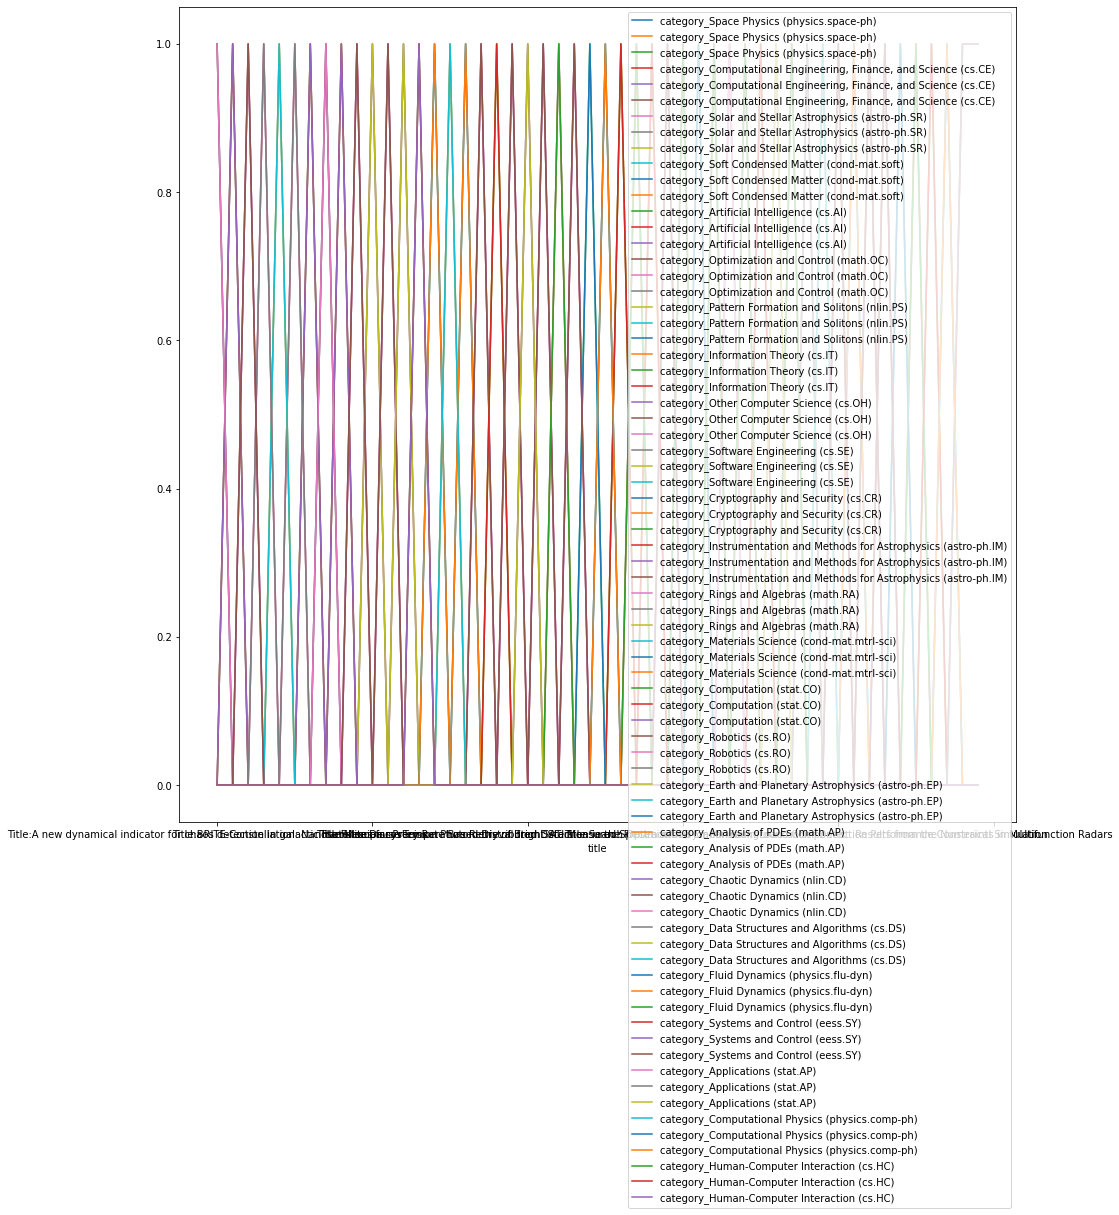

In [245]:
categoryBuff.plot(y=[f"category_{ind}" for ind in updatedCategorySet],figsize=(15,15))